# Data Science in Practice - Cleaning - 2001

## Cleaning the Ascents Datasets

Author : Eoghan Cunningham

In [2]:
import pandas as pd
import numpy as np
import re
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

We can begin by importing our complete dataset from the csv file. There is an addition index column here that we should drop.

In [3]:
ascents = pd.read_csv('../data/ascents_data_with_climber_info.csv').drop('Unnamed: 0', axis = 1)
ascents.sample(5)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade
31492,L'Horla,"?Jun, 2011",Lead rpt,NaN,76046,E1,Curbar Edge,Stanage Popular,HVS,E2
55352,Shadrach,"20 Oct, 2012",Lead O/S,with adam C,153618,VS,Craig Bwlch y Moch (Tremadog),Craig Bwlch y Moch (Tremadog),S,E1
37791,Great North Road,"22 Feb, 2009",Lead rpt,with Andrew Sloan,40584,HVS,Millstone Edge,Horseshoe Quarry,HVS,E2
21533,Ricochet,"29 May, 2007",Lead O/S,Very good. Well worth doingwith Dave Taylor,41486,E2,St. Govan's Head,Stanage Popular,E2,E4
28573,Wall Climb,"19 Apr, 2014",Lead dog,Not sure why I fell off. Perplexing. Good ro...,154655,VS,Curbar Edge,Stanage Popular,MVS,E2


In [4]:
ascents.shape

(58953, 10)

## 0. Justification of Filtering 

During the data retrieval process, the datset was filetered to leave only significant routes with a grade greater than S. Below this grade unsuccessful attempts are extremely rare and differentiating between the grades easier than this is very difficult. To properly justify this, we must consider the relationship between unsuccessful ascents and grades.

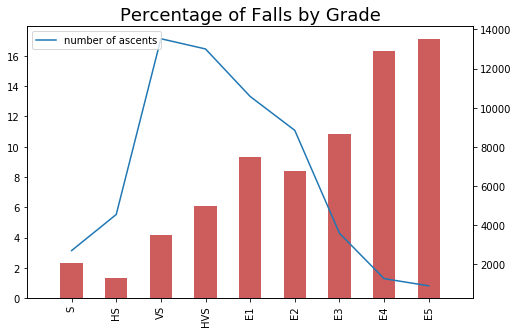

In [60]:
grade_index = pd.Series(['S','HS','VS','HVS','E1','E2','E3','E4','E5'])

failed = ['dog', 'dnf', 'G/U']
fails = ascents['style'].str.contains('|'.join(failed))

falls_by_grade = ascents[fails].grade.value_counts().reindex(grade_index)
ascents_by_grade = ascents.grade.value_counts().reindex(grade_index)

plt.figure(figsize = (8,5))
plt.title('Percentage of Falls by Grade', fontsize=18)

ax1 = ((falls_by_grade/ascents_by_grade)*100).plot.bar(color = 'indianred')
ax2 = ax1.twinx()
ax2 = ascents_by_grade.plot(label = 'number of ascents')
plt.legend(loc='upper left')
plt.xlim(-1,9)
plt.show()

## 1. Nan Values

Examining the completeness of the dataset below, we can see that there are many Nan values in our data. We consider the nature of these values: 

**Comments** : 
Nan comments should be permitted. While the comments are also useful, there is much to be learned by considering the success of the climber and their ability (max_grade).

**Climber info (max_grade, avg_grade, local_to)**:
Nan values for climber info occur when the data was not available for the climber. This happens only in rare cases where the ascent logged was the climbers only ascent. These ascents can be dropped from the dataframe as any analysis that can be performed without climber info could instead be done on the 'climber_ascents' dataset.



In [5]:
ascents.isna().sum()

name             0
date             0
style            0
comment       9277
climber_id       0
grade            0
location         0
local_to        27
avg_grade       27
max_grade       27
dtype: int64

In [6]:
ascents = ascents.dropna(subset = ['local_to', 'avg_grade','max_grade'], how = 'all')
ascents.isna().sum()

name             0
date             0
style            0
comment       9268
climber_id       0
grade            0
location         0
local_to         0
avg_grade        0
max_grade        0
dtype: int64

In [7]:
ascents.shape

(58926, 10)

## 2. Using Comments

### Comments about Weather

We believe the comments may contain information which could indicate which ascents are affected by weather. We can begin by considering the relationship between comments that mention poor weather and the climbers performance on the route. 

Our hypothesis: "The rate of 'upsets' is higher for ascents associated with comments that mention bad weather."

For the extent of our analysis an *upset* will be defined as 'an unsuccessful attempt where the grade of the route is within the abilities of the climber'.

We must first define a function to mark each upset in our dataset

In [8]:
british_grades_dict = {'D': 0,'HD' : 0,'VD' : 0,'HVD' : 0,'MS' : 0, 
                       'S' : 1,'HS' : 2,'MVS' : 3,'VS' : 4,'HVS' : 5,
                       'E1' : 6,'E2' : 7,'E3' : 8,'E4' : 9,'E5' : 10,
                       'E6' : 11,'E7' : 12,'E8' : 13,'E9' : 14,'E10' : 14,
                       'E11' : 15, 'XS': 16, 'HXS' : 17}

The british_grades_dict defined above will allow us to enumerate grades for comparison. 

In [9]:
def check_upset(style, route_grade, climber_grade):
    # the style indicates (among other things) the success of the attempt
    # 'dog' and 'dnf' indicate unsuccessful attempts
    if 'dog' in style or 'dnf' in style or 'G/U' in style:
        if british_grades_dict[climber_grade] >= british_grades_dict[route_grade] :
            return 1
        else : return 0
    else : return 0    

Applying this to our dataframe we can add an extra column 'upset' containing binary values indicating if the ascent was an upset

In [10]:
ascents['upset'] = ascents.apply(lambda row: check_upset(\
                                                         row['style'],
                                                         row['grade'],
                                                         row['max_grade'],
                                                        ), axis = 1)
ascents.sample(10)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset
25916,Anyone for Stennis,"26 May, 1991",Lead O/S,with Beak 2,199444,E2,Stennis Head,Stanage Popular,E1,E5,0
8239,Blanco,"4 Aug, 2017",AltLd O/S,with Jenn_Stretton,122457,HVS,Gogarth South Stack,Coupeau,VS,E4,0
38854,Embankment 2,"21 Aug, 2011",Lead O/S,Brilliant climb but tough for the grade.with Ken,63886,VS,Millstone Edge,Stanage Popular,VS,E2,0
43843,Piccadilly Circus,"3 Aug, 2018",Lead rpt,Just bloody brilliant,65335,E2,Millstone Edge,Stanage Popular,HVS,E9,0
38261,Embankment 1 - First Pitch,"13 Jul, 2014",Lead O/S,I thought this was harder than the first pitch...,185705,VS,Millstone Edge,Stanage Popular,MVS,E1,0
56316,Knell for a Jackdaw,"14 May, 2013",AltLd O/S,NaN,156492,S,Craig Bwlch y Moch (Tremadog),Burbage North,MS,VS,0
39230,Embankment 3,13 Apr2019,Lead O/S,with SFrancis,180130,E1,Millstone Edge,St. Govan's Head,E1,E2,0
31913,The Toy,"20 Feb, 2008",Lead dog,with Laurence Everitt,60505,E1,Curbar Edge,Geyikbayiri - Upper Tier,VS,E3,1
10141,Toiler on the Sea,"4 Jun, 2011",Lead O/S,with steve,114270,E2,Gogarth North Stack and Main Cliff,Holyhead Mountain,HVS,E5,0
17718,Colossus,"11 Apr, 2011",Lead O/S,Doesnt feel like a slate route! Top layback fe...,38705,E3,Rainbow Slab Area,Ceuse (Céüse),E1,E5,0


We can use this new column to compare the rate of upset for ascents that mention bad weather with those that don't.

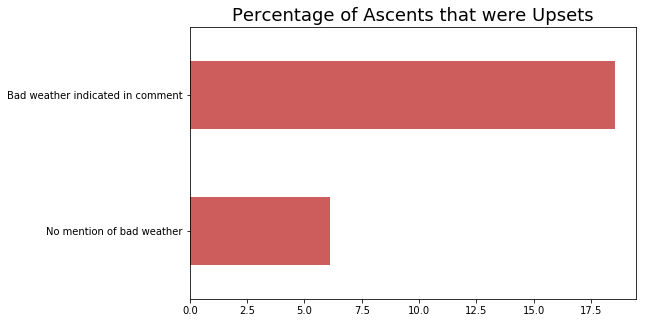

In [63]:
bad_weather_terms = ['rain','storm','wet','hail','snow','sleet']
bad_weather_ascents = ascents.replace(np.nan, '-').comment.str.contains('|'.join(bad_weather_terms))

plt.figure(figsize = (8,5))
plt.title('Percentage of Ascents that were Upsets', fontsize=18)
pd.Series({'No mention of bad weather':ascents[~bad_weather_ascents].upset.mean() * 100,
           'Bad weather indicated in comment':ascents[bad_weather_ascents].upset.mean() * 100})\
        .plot.barh(color = 'IndianRed')
plt.show()

In [12]:
stats.ttest_ind(ascents[~bad_weather_ascents].upset,ascents[bad_weather_ascents].upset)

Ttest_indResult(statistic=-17.020617312452245, pvalue=8.2569177763078e-65)

From the above analysis I am confident that ascents that mention bad weather are unreliable and that the success of the climber was influenced by the conditions. 

We can also consider the rate at which climbers are commenting. To do this we must clean the comments column. For any ascents where the climber has listed a partner, this info is appended to the comment. If the climber leaves no comment but lists a partner, the comment field will not be empty. To accurately consider the number of comments in our dataset we must remove any comments that simply list the partner. 


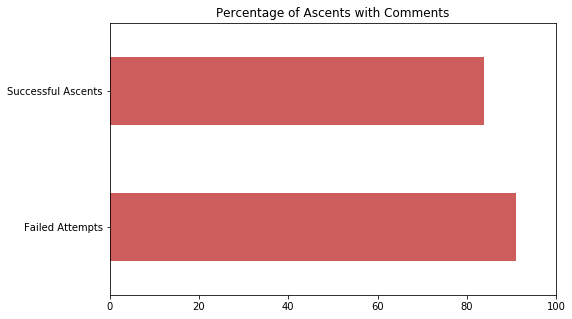

In [13]:
plt.figure(figsize = (8,5))

plt.xlim([0,100])
percent_failed_with_comments = (1 - ascents[fails].isna().sum().comment / len(ascents[fails])) * 100
percent_success_with_comments = (1 - ascents[~fails].isna().sum().comment / len(ascents[~fails])) * 100
pd.Series({'Failed Attempts' : percent_failed_with_comments,
          'Successful Ascents' : percent_success_with_comments}).plot.barh(color = 'IndianRed', 
                                                                          title = 'Percentage of Ascents with Comments')

plt.show()

In [56]:
def drop_partner_only_comments(comment):
    return np.nan if re.match(r'^with ((?!with).)*$', str(comment)) else comment

The above function drops any comments beginning with 'with', with the exception of comments that contain a second 'with'. If a comment is simply listing partners it will not contain a second 'with'.

In [57]:
ascents.comment = ascents.comment.map(drop_partner_only_comments)
ascents.isna().sum()

name              0
date              0
style             0
comment       36611
climber_id        0
grade             0
location          0
local_to          0
avg_grade         0
max_grade         0
upset             0
dtype: int64

It seems many of our comments were simply listing partners and have been replaced with Nan values. 

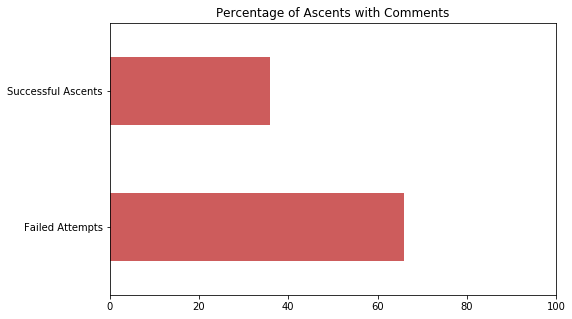

In [58]:
fails = ascents['style'].str.contains('|'.join(failed))

plt.figure(figsize = (8,5))
plt.title('Percentage of Sandbags by Location', fontsize=18)

plt.xlim([0,100])
percent_failed_with_comments = (1 - ascents[fails].isna().sum().comment / len(ascents[fails])) * 100
percent_success_with_comments = (1 - ascents[~fails].isna().sum().comment / len(ascents[~fails])) * 100
pd.Series({'Failed Attempts' : percent_failed_with_comments,
          'Successful Ascents' : percent_success_with_comments}).plot.barh(color = 'IndianRed', 
                                                                          title = 'Percentage of Ascents with Comments')

plt.show()

From the above results, we can see climbers are considerably more likely to comment on unsuccessful attempts. Perhaps this is influenced by ego. Whatever the reason, it improves our confidence in the completeness of the above bad-weather analysis. We can now remove the bad-weather ascents. 

In [19]:
ascents = ascents[~bad_weather_ascents]

In [20]:
ascents.shape

(57794, 11)

## Naming. 

We can shorten the names of certain locations to improve the legibility of our later visualisations.

In [21]:
ascents = ascents.replace("Gogarth North Stack and Main Cliff", "Gogarth North/Main")
ascents = ascents.replace("Craig Bwlch y Moch (Tremadog)", "Tremadog")
ascents = ascents.replace("Clogwyn Du'r Arddu (Cloggy)", "Cloggy")

In [22]:
ascents.sample(50)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset
257,Blind Pew,"17 Oct, 2018",AltLd O/S,NaN,92409,E2,Fair Head,Wanaka,E3,E7,0
17071,Bela Lugosi is Dead,"17 Apr, 2015",Lead O/S,Last climb of the Wales tripwith Aiden Chitty,148131,E1,Rainbow Slab Area,Bosigran,MVS,E3,0
46030,Vember,"?Jul, 2009",Lead O/S,NaN,132872,E1,Cloggy,Tremadog,E1,E3,0
50766,The Fang,"?Nov, 2006",AltLd dog,Rope drag was an issue on top slab pitch!with ...,40329,HVS,Tremadog,Port Eynon,E1,E1,1
22400,War Crime,"21 Aug, 2018",Lead O/S,NaN,38223,E2,St. Govan's Head,Chulilla,E2,E5,0
55924,Nifl-Heim,"??, 2003",Lead O/S,NaN,2442,HVS,Tremadog,Tremadog,VS,E1,0
21880,The Arrow,"23 May, 2015",Lead O/S,NaN,203135,E1,St. Govan's Head,Millstone Edge,HVS,E3,0
11527,A Dream of White Horses,"17 Nov, 2011",AltLd O/S,P 2&4 started on ledges. Went way too high on ...,99392,HVS,Gogarth North/Main,Stanage Popular,VS,E3,0
51674,One Step in the Clouds,"8 Jun, 2015",AltLd O/S,I just led the last easy pitch.with Pete,172934,VS,Tremadog,Wyndcliff Quarry,HS,E2,0
17567,Catrin,"6 Oct, 2012",Lead O/S,NaN,21959,E2,Rainbow Slab Area,Stanage Popular,VS,E4,0


In [23]:
ascents.to_csv('../data/ascents_cleaned.csv')